Here is the Clark-Wright Saving Algorith put into Python. The purpose of this algorithm is if you have an origin (let's say a Distribution Center) and you have n amount of nodes that need product. This algorithm can take in the max capacity of each route to determine different routes to fulfill demand while reducing overall distance traveled

Pros:
Near optimal results
Relatively quick
Determines distance with Earth curvature in mind


Cons:
Not necessarily most optimal
Only considers one origin and one overall max capacity

Step 1: Let's randomly generate nodes around our origin. Let's say our DC is in the center of Massachusets and we'll have 20 stores with demand between 0-100 and a max capacity of each route at 300.

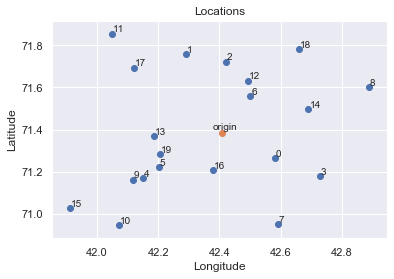

For comparison, to and from each would be a total distance of: 878.6084166674536


,Lat,Long,Demand,DistFromSource
0,42.581923,71.264889,31.873214,13.475933
1,42.290731,71.759072,3.342346,20.851085
2,42.421950,71.721878,79.990568,17.347941
3,42.728080,71.180084,36.662010,24.445830
4,42.149166,71.169498,20.266995,20.889281
5,42.201579,71.219976,51.397107,16.454839
6,42.500936,71.558100,27.946462,11.053773
7,42.589635,70.950129,65.298502,25.374835
8,42.888729,71.600373,89.644171,35.068267
9,42.117776,71.162507,62.621288,22.943023


In [607]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools

#set seaborn
sns.set()

#Set # of Nodes that need deliveries (for random generation) and max capacity per route
n = 20
maxcap = 300

#Get our source and destinations (randomly generated)
source = np.array([42.4072, 71.3824]) #LatLong of our DC in Massachusetts
destinations = np.random.random((n,2)) -.5 + source #For example, get 20 destinations near our source
demand = np.random.random((n,1)) * 100
df = pd.DataFrame({"Lat": destinations[:,0], "Long": destinations[:,1]})

#Make function to determine distance between two LatLongs
def latlongdiff(destination1, destination2):
    destination1 = destination1 * (math.pi/180) #LatLong should alreay be in degrees
    destination2 = destination2 * (math.pi/180)
    desDiff = 3959*(math.acos(math.sin(destination1[0]) * math.sin(destination2[0]) + 
                            math.cos(destination1[0]) * math.cos(destination2[0]) *
                            math.cos(destination1[1] - destination2[1])))
    return desDiff

#Make Panel Data of our Data
df = pd.DataFrame({"Lat": destinations[:,0], "Long": destinations[:,1]})
df["Demand"] = demand
df["DistFromSource"] = [latlongdiff(x, source) for x in destinations]

#Make a plot of starting data
plt.scatter(destinations[:,0], destinations[:,1])
plt.scatter(source[0], source[1])
for i in df.index:
    plt.text(df.iloc[i,0]+.003, df.iloc[i,1]+0.008, i, fontsize=10)
plt.text(source[0]-.03,source[1]+0.018, "origin", fontsize=10)
plt.xlabel('Longitude')
plt.ylabel("Latitude")
plt.title('Locations')
plt.show()

print("For comparison, to and from each would be a total distance of:", np.sum([latlongdiff(i, source) for i in destinations])*2)####
df


Step 2: Let's run our algorithm to get our routes. If there's any routes that cannot fall into route due to capacity constraints, there will be a route generated just for that route.

In [608]:
# Get all possible location combos
combos = list(itertools.combinations(list(range(n)),2))
desti = []
destj = []
savings = []

#Gather each combo's savings if a connection is made
for i, j in combos:
    savings.append(df.iloc[i,3] + df.iloc[j,3] - latlongdiff(df.iloc[i,0:2], df.iloc[j,0:2]))
    desti.append(i)
    destj.append(j)
    
#Combine our data and sort Saving combos in descending order    
sij = pd.DataFrame({'Dest_i' : desti, 'Dest_j': destj, 'Savings':savings}).sort_values('Savings', ascending= False).reset_index(drop=True)

#Create DataFrame to fill in data and record nodes that will be locked
paths = pd.DataFrame({"Route": [], "End_i": [], "End_j": [], "CapReached": [], "Savings": []})
lockedNodes = []

for index, i in enumerate(sij.values):
    ei = paths["End_i"].values
    ej = paths["End_j"].values
    #print("Step: ", str(index), "\n") ##For troubleshooting if needed
    #print(paths) ##Fore troubleshooting if needed
    #print(lockedNodes)
    
    #If a locked node is referenced, don't consider that combo
    if i[0] in lockedNodes and i[1] in lockedNodes:
        continue
    #if the Max Capacity between two potential connections is over the limit, don't consider that combo
    if df.loc[i[0],"Demand"] + df.loc[i[1],"Demand"] > maxcap:
        continue
    #If a combo is not yet references, 
    if ((i[0] not in ei and i[0] not in ej) and (i[1] not in ei and i[1] not in ej)) and (i[0] not in lockedNodes and i[1] not in lockedNodes): #Make new routes
        paths = paths.append({"Route": str(i[0])+"-"+str(i[1]), "End_i": i[0], "End_j": i[1], 
                              "CapReached": df.loc[i[0],"Demand"] + df.loc[i[1],"Demand"], 
                              "Savings": i[2]}, ignore_index= True)
        continue
    ######## Below code considers combining shorter routes
    if ((i[0] in ei or i[0] in ej) and (i[1] in ei or i[1] in ej)): #Add in comboing routes
        #continue #Uncomment this out if you want to not consider combining shorter routes
        if i[0] in ei and i[1] in ej:
            if paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_j"]==i[1],"CapReached"].values[0] > maxcap:
                continue
            elif paths[paths["End_i"]==i[0]].index == paths[paths["End_j"]==i[1]].index:
                continue
            else:
                lockedNodes.append(i[0])
                lockedNodes.append(i[1])
                paths.loc[paths["End_i"]==i[0], "Route"] = paths.loc[paths["End_j"]==i[1], "Route"].values[0] + "-" + paths.loc[paths["End_i"]==i[0], "Route"].values[0]
                paths.loc[paths["End_i"]==i[0], "CapReached"] = paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_j"]==i[1],"CapReached"].values[0]
                paths.loc[paths["End_i"]==i[0], "Savings"] = paths.loc[paths["End_i"]==i[0],"Savings"].values[0] + paths.loc[paths["End_j"]==i[1],"Savings"].values[0] + i[2]
                _del = paths[paths["End_j"]==i[1]].index
                paths.loc[paths["End_i"]==i[0], "End_i"] = paths.loc[paths["End_j"]==i[1], "End_i"].values[0]
                paths = paths.drop(_del).reset_index(drop=True)
        #####
        if i[0] in ei and i[1] in ei: #special because needs reverse
            if paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_i"]==i[1],"CapReached"].values[0] > maxcap:
                continue
            elif paths[paths["End_i"]==i[0]].index == paths[paths["End_i"]==i[1]].index:
                continue
            else:
                lockedNodes.append(i[0])
                lockedNodes.append(i[1])
                paths.loc[paths["End_i"]==i[0], "Route"] = "-".join(reversed(paths.loc[paths["End_i"]==i[1], "Route"].values[0].split("-"))) + "-" + paths.loc[paths["End_i"]==i[0], "Route"].values[0]
                paths.loc[paths["End_i"]==i[0], "CapReached"] = paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_i"]==i[1],"CapReached"].values[0]
                paths.loc[paths["End_i"]==i[0], "Savings"] = paths.loc[paths["End_i"]==i[0],"Savings"].values[0] + paths.loc[paths["End_i"]==i[1],"Savings"].values[0] + i[2]
                _del = paths[paths["End_i"]==i[1]].index
                paths.loc[paths["End_i"]==i[0], "End_i"] = paths.loc[paths["End_i"]==i[1], "End_j"].values[0]
                paths = paths.drop(_del).reset_index(drop=True)
        #####
        if i[0] in ej and i[1] in ei:
            if paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_i"]==i[1],"CapReached"].values[0] > maxcap:
                continue
            elif paths[paths["End_j"]==i[0]].index == paths[paths["End_i"]==i[1]].index:
                continue
            else:
                lockedNodes.append(i[0])
                lockedNodes.append(i[1])
                paths.loc[paths["End_j"]==i[0], "Route"] = paths.loc[paths["End_j"]==i[0], "Route"].values[0] + "-" + paths.loc[paths["End_i"]==i[1], "Route"].values[0]
                paths.loc[paths["End_j"]==i[0], "CapReached"] = paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_i"]==i[1],"CapReached"].values[0]
                paths.loc[paths["End_j"]==i[0], "Savings"] = paths.loc[paths["End_j"]==i[0],"Savings"].values[0] + paths.loc[paths["End_i"]==i[1],"Savings"].values[0] + i[2]
                _del = paths[paths["End_i"]==i[1]].index
                paths.loc[paths["End_j"]==i[0], "End_j"] = paths.loc[paths["End_i"]==i[1], "End_j"].values[0]
                paths = paths.drop(_del).reset_index(drop=True)
        #####
        if i[0] in ej and i[1] in ej: #special because needs reverse
            if paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_j"]==i[1],"CapReached"].values[0] > maxcap:
                continue
            elif paths[paths["End_j"]==i[0]].index == paths[paths["End_j"]==i[1]].index:
                continue
            else:
                lockedNodes.append(i[0])
                lockedNodes.append(i[1])
                paths.loc[paths["End_j"]==i[0], "Route"] = paths.loc[paths["End_j"]==i[0], "Route"].values[0] + "-" + "-".join(reversed(paths.loc[paths["End_j"]==i[1], "Route"].values[0].split("-")))
                paths.loc[paths["End_j"]==i[0], "CapReached"] = paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_j"]==i[1],"CapReached"].values[0]
                paths.loc[paths["End_j"]==i[0], "Savings"] = paths.loc[paths["End_j"]==i[0],"Savings"].values[0] + paths.loc[paths["End_j"]==i[1],"Savings"].values[0] + i[2]
                _del = paths[paths["End_j"]==i[1]].index
                paths.loc[paths["End_j"]==i[0], "End_j"] = paths.loc[paths["End_j"]==i[1], "End_i"].values[0]
                paths = paths.drop(_del).reset_index(drop=True)
        continue
        
    ########### Below updates routes if a combo can be appended to an end of the route, sep w/ #####
    if (len(ei[ei==i[0]])==1 and i[0] not in ej) and (i[0] not in lockedNodes and i[1] not in lockedNodes):
        if paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + df.loc[i[1],"Demand"] > maxcap:
            continue
        else:
            lockedNodes.append(i[0])
            paths.loc[paths["End_i"]==i[0], "Route"] = str(i[1])+"-"+ paths.loc[paths["End_i"]==i[0],"Route"]
            paths.loc[paths["End_i"]==i[0], "CapReached"] = paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + df.loc[i[1],"Demand"]
            paths.loc[paths["End_i"]==i[0], "Savings"] = paths.loc[paths["End_i"]==i[0],"Savings"].values[0] + i[2]
            paths.loc[paths["End_i"]==i[0], "End_i"] = i[1]
    #####   
    if (len(ej[ej==i[0]])==1 and i[0] not in ei) and (i[0] not in lockedNodes and i[1] not in lockedNodes):
        if paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + df.loc[i[1],"Demand"] > maxcap:
            continue
        else:
            lockedNodes.append(i[0])
            paths.loc[paths["End_j"]==i[0], "Route"] = paths.loc[paths["End_j"]==i[0],"Route"] + "-" + str(i[1])
            paths.loc[paths["End_j"]==i[0], "CapReached"] = paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + df.loc[i[1],"Demand"]
            paths.loc[paths["End_j"]==i[0], "Savings"] = paths.loc[paths["End_j"]==i[0],"Savings"].values[0] + i[2]
            paths.loc[paths["End_j"]==i[0], "End_j"] = i[1]
    #####
    if (len(ei[ei==i[1]])==1 and i[1] not in ej) and (i[1] not in lockedNodes and i[0] not in lockedNodes):
        if paths.loc[paths["End_i"]==i[1],"CapReached"].values[0] + df.loc[i[0],"Demand"] > maxcap:
            continue
        else:
            lockedNodes.append(i[1])
            paths.loc[paths["End_i"]==i[1], "Route"] = str(i[0])+"-"+ paths.loc[paths["End_i"]==i[1],"Route"]
            paths.loc[paths["End_i"]==i[1], "CapReached"] = paths.loc[paths["End_i"]==i[1],"CapReached"].values[0] + df.loc[i[0],"Demand"]
            paths.loc[paths["End_i"]==i[1], "Savings"] = paths.loc[paths["End_i"]==i[1],"Savings"].values[0] + i[2]
            paths.loc[paths["End_i"]==i[1], "End_i"] = i[0]
    #####
    if (len(ej[ej==i[1]])==1 and i[1] not in ei) and (i[1] not in lockedNodes and i[0] not in lockedNodes):
        if paths.loc[paths["End_j"]==i[1],"CapReached"].values[0] + df.loc[i[0],"Demand"] > maxcap:
            continue
        else:
            lockedNodes.append(i[1])
            paths.loc[paths["End_j"]==i[1], "Route"] = paths.loc[paths["End_j"]==i[1],"Route"]+"-"+str(i[0])
            paths.loc[paths["End_j"]==i[1], "CapReached"] = paths.loc[paths["End_j"]==i[1],"CapReached"].values[0] + df.loc[i[0],"Demand"]
            paths.loc[paths["End_j"]==i[1], "Savings"] = paths.loc[paths["End_j"]==i[1],"Savings"].values[0] + i[2]
            paths.loc[paths["End_j"]==i[1], "End_j"] = i[0]

#Any routes that couldn't fit in another route (normally closer locations) need their own route
leftovers = set(df.index) - set(lockedNodes + list(paths["End_i"].values) + list(paths["End_j"]))
if len(leftovers) > 0:
    for lo in leftovers:
        paths = paths.append({"Route": str(lo) + ".0", "End_i": lo, "End_j": lo, #Need to change if char index
                              "CapReached": df.loc[lo,"Demand"], 
                              "Savings": 0}, ignore_index= True)
paths

,Route,End_i,End_j,CapReached,Savings
0,16.0-10.0-15.0-9.0-4.0-5.0-19.0-13.0,16.0,13.0,283.350702,249.551465
1,2.0-1.0-11.0-17.0,2.0,17.0,207.607333,117.221563
2,14.0-8.0-18.0-12.0-6.0,14.0,6.0,268.950174,132.404835
3,0.0-3.0-7.0,0.0,7.0,133.833727,61.660854


Step 3: Let's visualize the results and see the paths that were created!

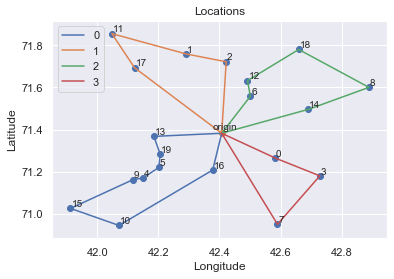

Maximum Capacity: 300 , # of Locations:  20
Total Savings in Distance: 560.8387161864955 saved out of an otherwise 878.6084166674536
Vehicle Utilization:  74.47849465805879 %


,Route,End_i,End_j,CapReached,Savings
0,16.0-10.0-15.0-9.0-4.0-5.0-19.0-13.0,16.0,13.0,283.350702,249.551465
1,2.0-1.0-11.0-17.0,2.0,17.0,207.607333,117.221563
2,14.0-8.0-18.0-12.0-6.0,14.0,6.0,268.950174,132.404835
3,0.0-3.0-7.0,0.0,7.0,133.833727,61.660854


In [609]:
#leftover = list(df.index).drop(lockedNodes)
for index, route in enumerate(paths["Route"].str.replace("\.0", "")):
    x = [source[0]]
    y = [source[1]]
    for dest in route.split("-"):
        x.append(df.loc[int(dest),"Lat"])
        y.append(df.loc[int(dest),"Long"])
    x.append(source[0])
    y.append(source[1])
    plt.plot(x, y)   
plt.scatter(destinations[:,0], destinations[:,1])
plt.scatter(source[0], source[1])
for i in df.index:
    plt.text(df.iloc[i,0]+.003, df.iloc[i,1]+0.008, i, fontsize=10)
plt.text(source[0]-.03,source[1]+0.018, "origin", fontsize=10)
plt.xlabel('Longitude')
plt.ylabel("Latitude")
plt.title('Locations')
plt.legend(paths["Route"].index)
plt.show()

print("Maximum Capacity:", maxcap, ", # of Locations: ", len(df))
print("Total Savings in Distance:", paths["Savings"].sum(), "saved out of an otherwise", np.sum([latlongdiff(i, source) for i in destinations])*2)####
print("Vehicle Utilization: ", (paths["CapReached"].sum()/(len(paths)*maxcap))*100,"%")

paths
        

Below is the whole run from start to finish without the multiple steps. Can use to test my script over and over or insert your own origin and node data, update the demand, and see the result!

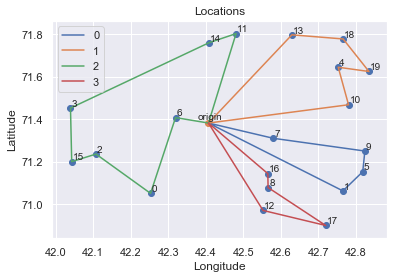

Maximum Capacity: 300 , # of Locations:  20
Total Savings in Distance: 619.0826801200247 saved out of an otherwise 957.4919601415786
Vehicle Utilization:  82.01098957721999 %


,Route,End_i,End_j,CapReached,Savings
0,1.0-5.0-9.0-7.0,1.0,7.0,236.583179,134.614917
1,13.0-18.0-19.0-4.0-10.0,13.0,10.0,212.951296,201.278045
2,6.0-0.0-2.0-15.0-3.0-14.0-11.0,6.0,11.0,269.006478,169.849689
3,12.0-17.0-8.0-16.0,12.0,16.0,265.590922,113.340029


In [570]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools

#set seaborn
sns.set()
n = 20
maxcap = 300

#Get our source and destinations
source = np.array([42.4072, 71.3824]) #LatLong of our DC in Massachusetts
destinations = np.random.random((n,2)) -.5 + source #For example, get 20 destinations near our source
demand = np.random.random((n,1)) * 100
df = pd.DataFrame({"Lat": destinations[:,0], "Long": destinations[:,1]})

#Make function to determine distance between two LatLongs
def latlongdiff(destination1, destination2):
    destination1 = destination1 * (math.pi/180) #LatLong should alreay be in degrees
    destination2 = destination2 * (math.pi/180)
    desDiff = 3959*(math.acos(math.sin(destination1[0]) * math.sin(destination2[0]) + 
                            math.cos(destination1[0]) * math.cos(destination2[0]) *
                            math.cos(destination1[1] - destination2[1])))
    return desDiff

#Make Panel Data of our Data
df = pd.DataFrame({"Lat": destinations[:,0], "Long": destinations[:,1]})
df["Demand"] = demand
df["DistFromSource"] = [latlongdiff(x, source) for x in destinations]

# Get all possible location combos
combos = list(itertools.combinations(list(range(n)),2))
desti = []
destj = []
savings = []

#Gather each combo's savings if a connection is made
for i, j in combos:
    savings.append(df.iloc[i,3] + df.iloc[j,3] - latlongdiff(df.iloc[i,0:2], df.iloc[j,0:2]))
    desti.append(i)
    destj.append(j)
    
#Combine our data and sort Saving combos in descending order    
sij = pd.DataFrame({'Dest_i' : desti, 'Dest_j': destj, 'Savings':savings}).sort_values('Savings', ascending= False).reset_index(drop=True)

#Create DataFrame to fill in data and record nodes that will be locked
paths = pd.DataFrame({"Route": [], "End_i": [], "End_j": [], "CapReached": [], "Savings": []})
lockedNodes = []

for index, i in enumerate(sij.values):
    ei = paths["End_i"].values
    ej = paths["End_j"].values
    #print("Step: ", str(index), "\n") ##For troubleshooting if needed
    #print(paths) ##Fore troubleshooting if needed
    
    #If a locked node is referenced, don't consider that combo
    if i[0] in lockedNodes and i[1] in lockedNodes:
        continue
    #if the Max Capacity between two potential connections is over the limit, don't consider that combo
    if df.loc[i[0],"Demand"] + df.loc[i[1],"Demand"] > maxcap:
        continue
    #If a combo is not yet references, 
    if ((i[0] not in ei and i[0] not in ej) and (i[1] not in ei and i[1] not in ej)) and (i[0] not in lockedNodes and i[1] not in lockedNodes): #Make new routes
        paths = paths.append({"Route": str(i[0])+"-"+str(i[1]), "End_i": i[0], "End_j": i[1], 
                              "CapReached": df.loc[i[0],"Demand"] + df.loc[i[1],"Demand"], 
                              "Savings": i[2]}, ignore_index= True)
        continue
    ######## Combining Paths when fluxing out, be sure to reset index after dropping later row
    if ((i[0] in ei or i[0] in ej) and (i[1] in ei or i[1] in ej)): #Add in comboing routes
        #continue #Uncomment this out if you want to not consider combining shorter routes
        if i[0] in ei and i[1] in ej:
            if paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_j"]==i[1],"CapReached"].values[0] > maxcap:
                continue
            elif paths[paths["End_i"]==i[0]].index == paths[paths["End_j"]==i[1]].index:
                continue
            else:
                lockedNodes.append(i[0])
                lockedNodes.append(i[1])
                paths.loc[paths["End_i"]==i[0], "Route"] = paths.loc[paths["End_j"]==i[1], "Route"].values[0] + "-" + paths.loc[paths["End_i"]==i[0], "Route"].values[0]
                paths.loc[paths["End_i"]==i[0], "CapReached"] = paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_j"]==i[1],"CapReached"].values[0]
                paths.loc[paths["End_i"]==i[0], "Savings"] = paths.loc[paths["End_i"]==i[0],"Savings"].values[0] + paths.loc[paths["End_j"]==i[1],"Savings"].values[0] + i[2]
                _del = paths[paths["End_j"]==i[1]].index
                paths.loc[paths["End_i"]==i[0], "End_i"] = paths.loc[paths["End_j"]==i[1], "End_i"].values[0]
                paths = paths.drop(_del).reset_index(drop=True)
        #####
        if i[0] in ei and i[1] in ei: #special because needs reverse
            if paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_i"]==i[1],"CapReached"].values[0] > maxcap:
                continue
            elif paths[paths["End_i"]==i[0]].index == paths[paths["End_i"]==i[1]].index:
                continue
            else:
                lockedNodes.append(i[0])
                lockedNodes.append(i[1])
                paths.loc[paths["End_i"]==i[0], "Route"] = "-".join(reversed(paths.loc[paths["End_i"]==i[1], "Route"].values[0].split("-"))) + "-" + paths.loc[paths["End_i"]==i[0], "Route"].values[0]
                paths.loc[paths["End_i"]==i[0], "CapReached"] = paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_i"]==i[1],"CapReached"].values[0]
                paths.loc[paths["End_i"]==i[0], "Savings"] = paths.loc[paths["End_i"]==i[0],"Savings"].values[0] + paths.loc[paths["End_i"]==i[1],"Savings"].values[0] + i[2]
                _del = paths[paths["End_i"]==i[1]].index
                paths.loc[paths["End_i"]==i[0], "End_i"] = paths.loc[paths["End_i"]==i[1], "End_j"].values[0]
                paths = paths.drop(_del).reset_index(drop=True)
        #####
        if i[0] in ej and i[1] in ei:
            if paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_i"]==i[1],"CapReached"].values[0] > maxcap:
                continue
            elif paths[paths["End_j"]==i[0]].index == paths[paths["End_i"]==i[1]].index:
                continue
            else:
                lockedNodes.append(i[0])
                lockedNodes.append(i[1])
                paths.loc[paths["End_j"]==i[0], "Route"] = paths.loc[paths["End_j"]==i[0], "Route"].values[0] + "-" + paths.loc[paths["End_i"]==i[1], "Route"].values[0]
                paths.loc[paths["End_j"]==i[0], "CapReached"] = paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_i"]==i[1],"CapReached"].values[0]
                paths.loc[paths["End_j"]==i[0], "Savings"] = paths.loc[paths["End_j"]==i[0],"Savings"].values[0] + paths.loc[paths["End_i"]==i[1],"Savings"].values[0] + i[2]
                _del = paths[paths["End_i"]==i[1]].index
                paths.loc[paths["End_j"]==i[0], "End_j"] = paths.loc[paths["End_i"]==i[1], "End_j"].values[0]
                paths = paths.drop(_del).reset_index(drop=True)
        #####
        if i[0] in ej and i[1] in ej: #special because needs reverse
            if paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_j"]==i[1],"CapReached"].values[0] > maxcap:
                continue
            elif paths[paths["End_j"]==i[0]].index == paths[paths["End_j"]==i[1]].index:
                continue
            else:
                lockedNodes.append(i[0])
                lockedNodes.append(i[1])
                paths.loc[paths["End_j"]==i[0], "Route"] = paths.loc[paths["End_j"]==i[0], "Route"].values[0] + "-" + "-".join(reversed(paths.loc[paths["End_j"]==i[1], "Route"].values[0].split("-")))
                paths.loc[paths["End_j"]==i[0], "CapReached"] = paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_j"]==i[1],"CapReached"].values[0]
                paths.loc[paths["End_j"]==i[0], "Savings"] = paths.loc[paths["End_j"]==i[0],"Savings"].values[0] + paths.loc[paths["End_j"]==i[1],"Savings"].values[0] + i[2]
                _del = paths[paths["End_j"]==i[1]].index
                paths.loc[paths["End_j"]==i[0], "End_j"] = paths.loc[paths["End_j"]==i[1], "End_i"].values[0]
                paths = paths.drop(_del).reset_index(drop=True)
        continue
        
    ########### Below updates routes if a combo can be appended to an end of the route, sep w/ #####
    if (len(ei[ei==i[0]])==1 and i[0] not in ej) and (i[0] not in lockedNodes and i[1] not in lockedNodes):
        if paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + df.loc[i[1],"Demand"] > maxcap:
            continue
        else:
            lockedNodes.append(i[0])
            paths.loc[paths["End_i"]==i[0], "Route"] = str(i[1])+"-"+ paths.loc[paths["End_i"]==i[0],"Route"]
            paths.loc[paths["End_i"]==i[0], "CapReached"] = paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + df.loc[i[1],"Demand"]
            paths.loc[paths["End_i"]==i[0], "Savings"] = paths.loc[paths["End_i"]==i[0],"Savings"].values[0] + i[2]
            paths.loc[paths["End_i"]==i[0], "End_i"] = i[1]
    #####   
    if (len(ej[ej==i[0]])==1 and i[0] not in ei) and (i[0] not in lockedNodes and i[1] not in lockedNodes):
        if paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + df.loc[i[1],"Demand"] > maxcap:
            continue
        else:
            lockedNodes.append(i[0])
            paths.loc[paths["End_j"]==i[0], "Route"] = paths.loc[paths["End_j"]==i[0],"Route"] + "-" + str(i[1])
            paths.loc[paths["End_j"]==i[0], "CapReached"] = paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + df.loc[i[1],"Demand"]
            paths.loc[paths["End_j"]==i[0], "Savings"] = paths.loc[paths["End_j"]==i[0],"Savings"].values[0] + i[2]
            paths.loc[paths["End_j"]==i[0], "End_j"] = i[1]
    #####
    if (len(ei[ei==i[1]])==1 and i[1] not in ej) and (i[1] not in lockedNodes and i[0] not in lockedNodes):
        if paths.loc[paths["End_i"]==i[1],"CapReached"].values[0] + df.loc[i[0],"Demand"] > maxcap:
            continue
        else:
            lockedNodes.append(i[1])
            paths.loc[paths["End_i"]==i[1], "Route"] = str(i[0])+"-"+ paths.loc[paths["End_i"]==i[1],"Route"]
            paths.loc[paths["End_i"]==i[1], "CapReached"] = paths.loc[paths["End_i"]==i[1],"CapReached"].values[0] + df.loc[i[0],"Demand"]
            paths.loc[paths["End_i"]==i[1], "Savings"] = paths.loc[paths["End_i"]==i[1],"Savings"].values[0] + i[2]
            paths.loc[paths["End_i"]==i[1], "End_i"] = i[0]
    #####
    if (len(ej[ej==i[1]])==1 and i[1] not in ei) and (i[1] not in lockedNodes and i[0] not in lockedNodes):
        if paths.loc[paths["End_j"]==i[1],"CapReached"].values[0] + df.loc[i[0],"Demand"] > maxcap:
            continue
        else:
            lockedNodes.append(i[1])
            paths.loc[paths["End_j"]==i[1], "Route"] = paths.loc[paths["End_j"]==i[1],"Route"]+"-"+str(i[0])
            paths.loc[paths["End_j"]==i[1], "CapReached"] = paths.loc[paths["End_j"]==i[1],"CapReached"].values[0] + df.loc[i[0],"Demand"]
            paths.loc[paths["End_j"]==i[1], "Savings"] = paths.loc[paths["End_j"]==i[1],"Savings"].values[0] + i[2]
            paths.loc[paths["End_j"]==i[1], "End_j"] = i[0]

#Any routes that couldn't fit in another route (normally closer locations) need their own route
leftovers = set(df.index) - set(lockedNodes + list(paths["End_i"].values) + list(paths["End_j"]))
if len(leftovers) > 0:
    for lo in leftovers:
        paths = paths.append({"Route": str(lo) +".0", "End_i": lo, "End_j": lo, #Change Route if char index
                              "CapReached": df.loc[lo,"Demand"], 
                              "Savings": 0}, ignore_index= True)

for index, route in enumerate(paths["Route"].str.replace("\.0", "")):
    x = [source[0]]
    y = [source[1]]
    for dest in route.split("-"):
        x.append(df.loc[int(dest),"Lat"])
        y.append(df.loc[int(dest),"Long"])
    x.append(source[0])
    y.append(source[1])
    plt.plot(x, y)   
plt.scatter(destinations[:,0], destinations[:,1])
plt.scatter(source[0], source[1])
for i in df.index:
    plt.text(df.iloc[i,0]+.003, df.iloc[i,1]+0.008, i, fontsize=10)
plt.text(source[0]-.03,source[1]+0.018, "origin", fontsize=10)
plt.xlabel('Longitude')
plt.ylabel("Latitude")
plt.title('Locations')
plt.legend(paths["Route"].index)
plt.show()

print("Maximum Capacity:", maxcap, ", # of Locations: ", len(df))
print("Total Savings in Distance:", paths["Savings"].sum(), "saved out of an otherwise", np.sum([latlongdiff(i, source) for i in destinations])*2)####
print("Vehicle Utilization: ", (paths["CapReached"].sum()/(len(paths)*maxcap))*100,"%")

paths